In [ ]:
!pip install pandas_ta

In [52]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import pandas as pd
import pandas_ta as ta
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pytz
import holidays

In [53]:
def fetch_daily_data(symbol, start_date, end_date=None):

  daily_data=yf.download(symbol, start=start_date, end=end_date)
  return daily_data

In [54]:
def add_indicators(df):
    df_with_indicators=df.copy()
    df_with_indicators['RSI'] = ta.rsi(df['Adj Close'], length=14)
    macd = ta.macd(df_with_indicators['Adj Close'], fast=12, slow=26, signal=9)
    df_with_indicators = pd.concat([df_with_indicators, macd], axis=1)
    df_with_indicators['MACD_Signal_Diff'] = df_with_indicators['MACD_12_26_9'] - df_with_indicators['MACDs_12_26_9']
    df_with_indicators = df_with_indicators.drop(['Open', 'High', 'Low', 'Close', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9'], axis=1)
    adx = ta.adx(df['High'], df['Low'], df['Adj Close'], length=14)
    df_with_indicators = pd.concat([df_with_indicators, adx], axis=1)
    bollinger_bands = ta.bbands(df['Adj Close'], length=20)
    df_with_indicators = pd.concat([df_with_indicators, bollinger_bands], axis=1)
    df_with_indicators['MACD_Signal_Diff_Percentage'] = df_with_indicators['MACD_Signal_Diff']/df_with_indicators['BBM_20_2.0']*100
    df_with_indicators['BBM_Normalised']=df_with_indicators['BBM_20_2.0']/df_with_indicators['Adj Close']*100
    df_with_indicators['Std_Dev_Normalised']=((df_with_indicators['BBU_20_2.0']-df_with_indicators['BBM_20_2.0'])/df_with_indicators['BBM_20_2.0'])*100
    df_with_indicators['Diff_wrt_StdDev']=(df_with_indicators['Adj Close']-df_with_indicators['BBM_20_2.0'])/(df_with_indicators['BBU_20_2.0']-df_with_indicators['BBM_20_2.0'])
    df_with_indicators = df_with_indicators.drop(['BBL_20_2.0', 'BBU_20_2.0', 'BBP_20_2.0', 'BBB_20_2.0', 'MACD_Signal_Diff', 'BBM_20_2.0'], axis=1)
    df_with_indicators['Vol_10day_SMA']=ta.sma(df['Volume'], length=10)
    df_with_indicators['Volume_ratio_to_10day_SMA']=df_with_indicators['Volume']/df_with_indicators['Vol_10day_SMA']
    df_with_indicators = df_with_indicators.drop(['Vol_10day_SMA','Volume'], axis=1)
    df_with_indicators['Target'] = (df_with_indicators['Adj Close'].shift(-1) > df_with_indicators['Adj Close']).astype(int)
    df_with_indicators.dropna(inplace=True)
    return df_with_indicators

    '''df['SMA'] = ta.sma(df['Adj Close'], length=20)
    df['EMA'] = ta.ema(df['Adj Close'], length=20)
    df['RSI'] = ta.rsi(df['Adj Close'], length=14)
    macd = ta.macd(df['Adj Close'])
    df['MACD'] = macd['MACD_12_26_9']
    df['MACD_signal'] = macd['MACDs_12_26_9']
    df['MACD_diff'] = macd['MACDh_12_26_9']
    df['ADX'] = ta.adx(df['High'], df['Low'], df['Adj Close'])['ADX_14']
    df['OBV'] = ta.obv(df['Adj Close'], df['Volume'])
    df['Target'] = (df['Adj Close'].shift(-1) > df['Adj Close']).astype(int)
    df=df.drop(['Close', 'Volume', 'Open', 'High', 'Low'], axis=1)
    df.dropna(inplace=True)
    return df'''

In [60]:
df=fetch_daily_data('ITC.NS',datetime(2020,1,1),datetime(2024,1,1))
df_2=add_indicators(df)

data_set = df_2.iloc[:, 0:11]#.values
pd.set_option('display.max_columns', None)

data_set.head(20)

[*********************100%%**********************]  1 of 1 completed


,Adj Close,RSI,ADX_14,DMP_14,DMN_14,MACD_Signal_Diff_Percentage,BBM_Normalised,Std_Dev_Normalised,Diff_wrt_StdDev,Volume_ratio_to_10day_SMA,Target
Date,,,,,,,,,,,
2014-02-17,158.528000,45.758286,31.086906,0.789787,1.686992,-0.235666,101.136364,1.990017,-0.564616,0.589692,0
2014-02-18,156.943207,41.430376,31.856618,0.729564,1.685809,-0.274472,101.965926,2.046611,-0.942056,0.760336,0
2014-02-19,156.819397,41.103297,32.554404,0.674397,1.562864,-0.289454,101.877473,2.134772,-0.863265,0.455371,0
2014-02-20,154.442230,35.335226,34.074928,0.624580,1.872256,-0.378594,103.171395,2.397791,-1.281975,1.028632,1
2014-02-21,157.289886,45.247446,35.004100,0.657062,1.727336,-0.298778,101.198836,2.434822,-0.486538,1.124352,1
2014-02-24,158.503220,48.845473,34.649993,0.844310,1.596740,-0.182016,100.359330,2.409124,-0.148620,0.708920,1
2014-02-25,159.444199,51.506958,33.567625,0.949837,1.476414,-0.058746,99.694055,2.285873,0.134252,0.950859,1
2014-02-26,162.811859,59.606873,31.288693,1.530997,1.358317,0.159642,97.688980,2.462720,0.960601,2.018312,0
2014-02-28,162.267059,57.921356,29.728125,1.601673,1.253771,0.268631,98.063506,2.576399,0.766471,1.780520,1


In [61]:
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data_set)
print(data_set_scaled)
#print(data_set_scaled.shape)

[[0.10694827 0.46751402 0.42048988 ... 0.36509872 0.09785861 0.        ]
 [0.10249828 0.41154247 0.43567683 ... 0.26725643 0.12617683 0.        ]
 [0.10215063 0.40731245 0.44944465 ... 0.28768126 0.07556816 0.        ]
 ...
 [0.90469676 0.6207252  0.14277633 ... 0.59590341 0.1141082  1.        ]
 [0.92373019 0.69549375 0.1457568  ... 0.73035931 0.28833064 0.        ]
 [0.91829204 0.66248194 0.15688822 ... 0.70862969 0.18181761 0.        ]]


In [62]:
# multiple feature from data provided to the model
X = []
#print(data_set_scaled[0].size)
#data_set_scaled=data_set.values
backcandles = 40
print(data_set_scaled.shape[0])
for j in range(10):#data_set_scaled[0].size):#2 columns are target not X
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):#backcandles+2
        X[j].append(data_set_scaled[i-backcandles:i, j])

X=np.moveaxis(X, [0], [2])

#Erase first elements of y because of backcandles to match X length
#del(yi[0:backcandles])
#X, yi = np.array(X), np.array(yi)
# Choose -1 for last column, classification else -2...
X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))
#y=sc.fit_transform(yi)
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X)
print(X.shape)
print(y)
print(y.shape)

2432
[[[0.10694827 0.46751402 0.42048988 ... 0.03868159 0.36509872 0.09785861]
  [0.10249828 0.41154247 0.43567683 ... 0.04139398 0.26725643 0.12617683]
  [0.10215063 0.40731245 0.44944465 ... 0.04561925 0.28768126 0.07556816]
  ...
  [0.13594261 0.44927238 0.22736069 ... 0.13187361 0.30585703 0.09812088]
  [0.14303473 0.53993233 0.20756885 ... 0.13309498 0.40309496 0.09700557]
  [0.15304721 0.64104311 0.19084437 ... 0.13172739 0.53972118 0.12371977]]

 [[0.10249828 0.41154247 0.43567683 ... 0.04139398 0.26725643 0.12617683]
  [0.10215063 0.40731245 0.44944465 ... 0.04561925 0.28768126 0.07556816]
  [0.0954757  0.33271574 0.47944566 ... 0.05822494 0.17914052 0.17070013]
  ...
  [0.14303473 0.53993233 0.20756885 ... 0.13309498 0.40309496 0.09700557]
  [0.15304721 0.64104311 0.19084437 ... 0.13172739 0.53972118 0.12371977]
  [0.15325583 0.64294037 0.18171076 ... 0.12562231 0.54971072 0.11996919]]

 [[0.10215063 0.40731245 0.44944465 ... 0.04561925 0.28768126 0.07556816]
  [0.0954757  0.3

In [63]:
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

1913
(1913, 40, 10)
(479, 40, 10)
(1913, 1)
(479, 1)
[[0.]
 [1.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
#tf.random.set_seed(20)
np.random.seed(10)

lstm_input = Input(shape=(backcandles, 10), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

Epoch 1/30


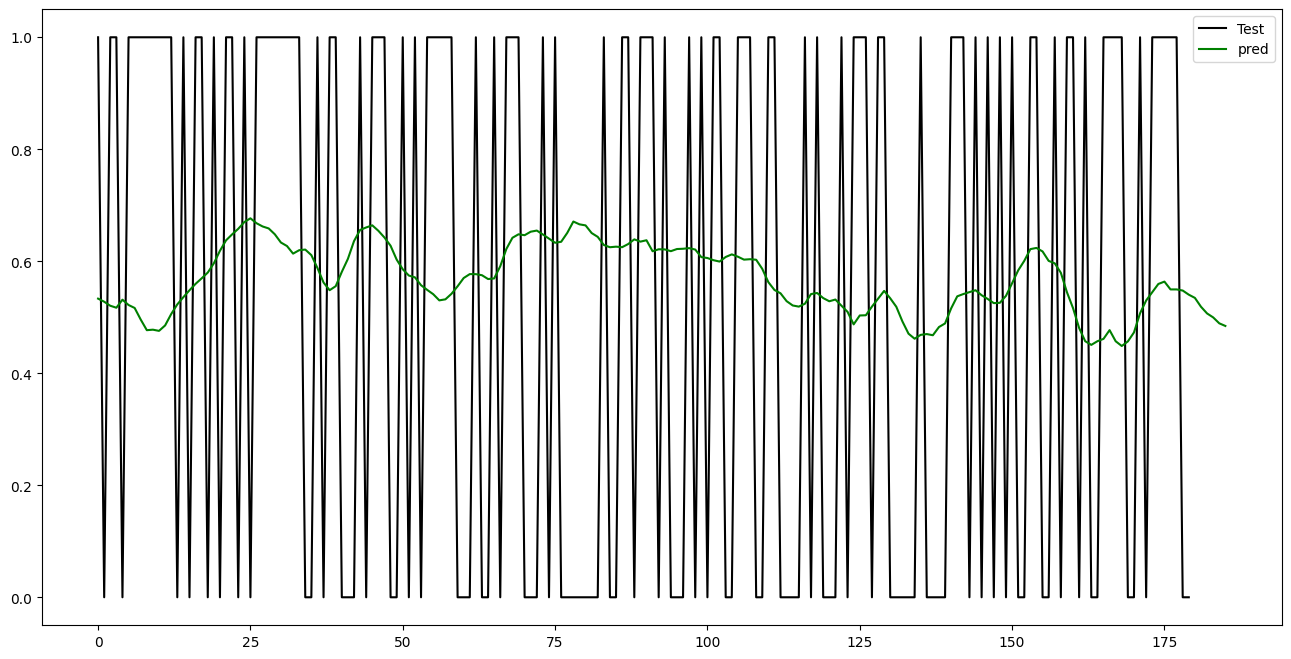

In [49]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()

In [50]:
# @title MACD_Signal_Diff

from matplotlib import pyplot as plt
df_2['MACD_Signal_Diff'].plot(kind='line', figsize=(8, 4), title='MACD_Signal_Diff')
plt.gca().spines[['top', 'right']].set_visible(False)

KeyError: 'MACD_Signal_Diff'